<a href="https://colab.research.google.com/github/bmcgregor22/reinforcement_learning_online_msds/blob/work/mywork/module7/lab_dueling_q_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Lab: Navigating the Lunar Lander with a Dueling Deep Q Network

### University of Virginia
### Reinforcement Learning
#### Last updated: February 27, 2024

---

## Bruce McGregor

#### Instructions:

You will work with the `LunarLander-v2` environment from `gymnasium` in this lab.  

An overview of the environment can be found [here](https://gymnasium.farama.org/).  
If you're curious about the source code, see [here](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/box2d/lunar_lander.py).

Your mission will be to implement a dueling deep Q -network using PyTorch.  
You might run this on Colab.

There are a few specific tasks outlined below for you to solve.

The bigger tasks will be to:

- Show that the algorithm works to train the agent in the environment
- Run episodes and show the results

**Submission**  
As you will likely have several files including this notebook, you can zip all files and submit.

---

![lunar](https://github.com/bmcgregor22/reinforcement_learning_online_msds/blob/work/mywork/module7/lunar_lander1.png?raw=1)

#### TOTAL POINTS: 12

---

**Hint:** Modules you may need to install include:

swig  
gym[box2d]  
gymnasium

#### 1) What is the penalty for crashing?  
**(POINTS: 1)**


The penalthy for crashing is negative 100 points.

#### 2) Set up the environment and run 2 steps by taking random actions.
**(POINTS: 1)**

In [1]:
!apt-get -y install swig
!pip install -U gymnasium[box2d] torch


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,601 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 125080 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

In [2]:
#This is a test script to make sure everything loaded correctly.

import gymnasium as gym
import numpy as np

env = gym.make("LunarLander-v3")
obs, info = env.reset(seed=42)


action = env.action_space.sample() #take a random action
next_obs, reward, terminated, truncated, info = env.step(action)

print("\nStep 1:")
print("  Action taken:", action)
print("  Reward:", reward)
print("  Terminated:", terminated, "Truncated:", truncated)
print("  Next obs sample:", np.round(next_obs, 3))

action = env.action_space.sample()  # another random action
next_obs, reward, terminated, truncated, info = env.step(action)
print("\nStep 2:")
print("  Action taken:", action)
print("  Reward:", reward)
print("  Terminated:", terminated, "Truncated:", truncated)
print("  Next obs sample:", np.round(next_obs, 3))


env.close()


Step 1:
  Action taken: 1
  Reward: 2.0804712989958616
  Terminated: False Truncated: False
  Next obs sample: [ 0.004  1.425  0.22   0.295 -0.003 -0.004  0.     0.   ]

Step 2:
  Action taken: 1
  Reward: 2.1746352363679207
  Terminated: False Truncated: False
  Next obs sample: [ 7.000e-03  1.431e+00  2.110e-01  2.690e-01 -1.000e-03  3.300e-02
  0.000e+00  0.000e+00]


#### 3) Briefly discuss your approach to solving the problem  
**(POINTS: 2)**

My approach to solving this problem is to create modular programs for the agent, the network, the replay buffer. I will leverage the Pytorch nn.module class for neural networks to create the network. I will create a separate script for training, and a separate file to run the application. I will set the hyperparameters up in a config file to make the code more readable. I will design the network using PyTorch best practices for RL, using two fully connected layers with ReLU activations for nonlinear relationships. The network will have three parts: a shared feature extractor, a value stream, and an advantage stream. During training, I will use two  network instantiations to serve as the online network and the target network, which will be periodically updated during training, through either a hard or soft update.

I used AI to help with code generation. I used  Chat GPT to suggest a coding strategy, and used Gemini in Colab to revise, edit, dbug, and add comments.  I walked through all code with Gemini to ensure I understood the functions, especially some of Pytorch conversions, which were a bit tricky.

I found using AI code walkthroughs to be very informative and helpful in grasping these algorithms and how to implement them.

In [3]:
%%writefile config.py

from dataclasses import dataclass

SEED = 42 # Random seed for reproducibility

@dataclass
class Config:
    # Environment Parameters
    env_id: str = "LunarLander-v3" # Environment ID

    # Training Parameters
    total_steps: int = 200_000 # Total number of steps to train for
    start_learning: int = 10_000 # Number of steps before training starts
    buffer_size: int = 200_000 # Size of the replay buffer
    batch_size: int = 128 # Batch size for training
    gamma: float = 0.99 # Discount factor
    lr: float = 5e-4 # Learning rate for the optimizer
    train_freq: int = 1 # Training frequency (train every N steps)
    target_update_freq: int = 1_000  # Frequency to update the target network (hard copy)
    tau: float = 0.005                 # Interpolation factor for soft target updates (1.0 for hard copy)
    grad_clip: float = 10.0 # Gradient clipping value
    reward_clip: float | None = 1.0  # Clip rewards to [-1, 1] if not None

    # Exploration Parameters
    eps_start: float = 1.0 # Starting value of epsilon for epsilon-greedy exploration
    eps_end: float = 0.05 # Ending value of epsilon for epsilon-greedy exploration
    eps_decay_steps: int = 200_000 # Number of steps over which epsilon decays

Writing config.py


#### 4) Create supporting code files (`.py` format) to create the agent, train, and run episodes
**(POINTS: 6)**

Your code should include:

- **(POINTS: 1)** A class for the dueling DQN agent
- **(POINTS: 1)** An architecture with separate Value and Advantage streams
- **(POINTS: 1)** A method called `forward()` for the forward pass of the algorithm
- **(POINTS: 1)** A replay buffer
- **(POINTS: 1)** A training function
- **(POINTS: 1)** A function to run episodes

In [4]:
%%writefile network.py

import torch
import torch.nn as nn
from typing import Tuple

class DuelingQNetwork(nn.Module): ##inherits from torch.nn.Module
    """
    Dueling Deep Q-Network (Dueling DQN) architecture.

    This network implements the dueling architecture by splitting the network
    into a shared feature extractor, a value stream (V), and an advantage
    stream (A). The Q-values are computed by combining V and A.
    """
    def __init__(self, state_dim: int, n_actions: int, hidden: Tuple[int, int] = (256, 256)):
        """
        Initializes the DuelingQNetwork.

        Args:
            state_dim: The dimension of the input state space.
            n_actions: The number of possible actions in the environment.
            hidden: A tuple specifying the number of units in the hidden layers
                    of the shared feature extractor.
        """
        super().__init__() #calls the parent class init to set up nn

        # Shared feature extractor
        self.feature = nn.Sequential(
            nn.Linear(state_dim, hidden[0]),
            nn.ReLU(),
            nn.Linear(hidden[0], hidden[1]),
            nn.ReLU(),
        )

        # Value stream (estimates V(s))
        self.value = nn.Sequential(
            nn.Linear(hidden[1], 128),
            nn.ReLU(),
            nn.Linear(128, 1), # Output a single value for V(s)
        )

        # Advantage stream (estimates A(s, a))
        self.advantage = nn.Sequential(
            nn.Linear(hidden[1], 128),
            nn.ReLU(),
            nn.Linear(128, n_actions), # Output a value for each action
        )

    def forward(self, x):
        """
        Defines the forward pass of the network.

        Args:
            x: The input tensor representing a batch of states.

        Returns:
            A tensor of Q-values for each action in the input states.
        """
        # Pass input through the shared feature extractor
        z = self.feature(x)

        # Get the state value from the value stream
        v = self.value(z)                        # [B, 1]

        # Get the advantage for each action from the advantage stream
        a = self.advantage(z)                    # [B, A]

        # Center the advantages for identifiability
        # Subtracting the mean of advantages doesn't change the relative order
        # of actions but helps in separating the roles of V and A.
        a = a - a.mean(dim=1, keepdim=True)      # center A for identifiability

        # Combine value and advantage to get Q-values
        # Q(s, a) = V(s) + A(s, a)
        return v + a                              # [B, A]

Writing network.py


In [5]:
%%writefile replay_buffer.py

from collections import deque, namedtuple
import random
import numpy as np
import torch

# Define a namedtuple to represent a single transition in the environment
# A transition includes the state, the action taken, the reward received,
# the next state, and whether the episode ended (done flag).
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
  """
  A simple replay buffer to store and sample experiences for training.
  It uses a deque (double-ended queue) with a fixed maximum capacity.
  """
  def __init__(self, capacity: int, seed: int =42):
    '''
    Initializes the ReplayBuffer.

    Args:
        capacity: The maximum number of transitions to store in the buffer.
        seed: A random seed for reproducibility.
    '''
    # Create a deque with a maximum length. When the deque is full,
    # adding new elements automatically removes elements from the opposite end (FIFO).
    self.buffer = deque(maxlen=capacity)
    # Initialize a random number generator for sampling
    self.rng = random.Random(seed)

  def __len__(self):
    """Returns the current number of transitions stored in the buffer."""
    return len(self.buffer)

  def add(self, state, action, reward, next_state, done):
    """
    Adds a new transition to the replay buffer.

    Args:
        state: The current state observation.
        action: The action taken in the state.
        reward: The reward received after taking the action.
        next_state: The observation of the state after taking the action.
        done: A boolean flag indicating if the episode terminated or was truncated.
    """
    # Append the new transition (as a Transition namedtuple) to the right side of the deque.
    self.buffer.append(Transition(state, action, reward, next_state, done))

  def sample(self, batch_size: int, device: torch.device):
      """
      Randomly samples a minibatch of transitions from the buffer and
      returns them as PyTorch tensors, ready for training.

      Args:
          batch_size: The number of transitions to sample.
          device: The PyTorch device (e.g., 'cuda' or 'cpu') to place the tensors on.

      Returns:
          A tuple of PyTorch tensors: (states, actions, rewards, next_states, dones).
      """
      # Randomly sample 'batch_size' number of transitions from the buffer.
      # By sampling randomly from the replay buffer, you break correlations
      # between consecutive experiences, which is crucial for the stability and
      # effectiveness of off-policy reinforcement learning algorithms like DQN.
      batch = self.rng.sample(self.buffer, batch_size)

      # Convert the sampled batch of transitions into separate PyTorch tensors.
      # This step prepares the data in the required format for PyTorch neural networks.

      # Stack individual state NumPy arrays into a single batch NumPy array,
      # then convert to a PyTorch tensor of type float32 and move to the specified device.
      state  = torch.tensor(np.stack([b.state  for b in batch]), dtype=torch.float32, device=device)

      # Convert action list to a PyTorch tensor of type long (for discrete actions),
      # move to device, and add an extra dimension (unsqueeze(1)) for consistency with gathering operations.
      action  = torch.tensor([b.action   for b in batch], dtype=torch.long,   device=device).unsqueeze(1) # Actions are long tensors

      # Convert reward list to a PyTorch tensor of type float32,
      # move to device, and add an extra dimension (unsqueeze(1)) for consistency.
      reward  = torch.tensor([b.reward   for b in batch], dtype=torch.float32, device=device).unsqueeze(1) # Rewards are float tensors

      # Stack individual next_state NumPy arrays into a batch NumPy array,
      # then convert to a PyTorch tensor of type float32 and move to the specified device.
      next_state = torch.tensor(np.stack([b.next_state for b in batch]), dtype=torch.float32, device=device)

      # Convert done list (boolean flags) to a PyTorch tensor of type float32 (0.0 or 1.0),
      # move to device, and add an extra dimension (unsqueeze(1)). Used for masking terminal states in target calculation.
      done  = torch.tensor([b.done for b in batch], dtype=torch.float32, device=device).unsqueeze(1)

      return state, action, reward, next_state, done

Writing replay_buffer.py


In [6]:
%%writefile agent.py

# agent.py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from config import Config
from network import DuelingQNetwork
from replay_buffer import ReplayBuffer

class DuelingDDQNAgent:
    """
    Implements a Dueling Double Deep Q-Network (Dueling DDQN) agent.
    """
    def __init__(self, state_dim: int, n_actions: int, cfg: Config, seed: int = 42):
        """
        Initializes the Dueling DDQN agent.

        Args:
            state_dim: Dimension of the state space.
            n_actions: Number of possible actions.
            cfg: Configuration object containing hyperparameters.
            seed: Random seed for reproducibility.
        """
        self.cfg = cfg
        self.n_actions = n_actions
        # Determine the device to use for tensors (GPU if available, otherwise CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Set random seeds for reproducibility
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Initialize the online and target Q-networks
        self.q = DuelingQNetwork(state_dim, n_actions).to(self.device)
        self.q_target = DuelingQNetwork(state_dim, n_actions).to(self.device)
        # Copy initial weights from the online network to the target network
        self.q_target.load_state_dict(self.q.state_dict())
        # Set the target network to evaluation mode (gradients are not computed)
        self.q_target.eval()

        # Initialize the optimizer for the online network
        self.opt = optim.Adam(self.q.parameters(), lr=cfg.lr)
        # Initialize the replay buffer
        self.rb = ReplayBuffer(cfg.buffer_size, seed=seed)

        # Exploration parameter (epsilon)
        self.eps = cfg.eps_start
        # Global step counter
        self.global_step = 0

    @torch.no_grad() # Decorator to disable gradient computation within this method
    def act(self, state_np: np.ndarray) -> int:
        """
        Selects an action using an epsilon-greedy policy on the online network.

        Args:
            state_np: The current state observation as a NumPy array.

        Returns:
            The selected action as an integer.
        """
        # Epsilon-greedy exploration: choose random action with probability epsilon
        if np.random.rand() < self.eps:
            return np.random.randint(self.n_actions)
        # Greedy action selection: choose action with the highest Q-value
        else:
            # Convert state to tensor and add a batch dimension
            s = torch.tensor(state_np, dtype=torch.float32, device=self.device).unsqueeze(0)
            # Get Q-values from the online network
            q = self.q(s)                   # [1, A]
            # Return the index of the action with the maximum Q-value
            return int(q.argmax(dim=1))     # greedy action

    def update(self):
        """
        Performs one learning step (update) of the agent's Q-network.
        Samples a batch from the replay buffer and updates the online network
        using the Double DQN and Dueling DQN concepts.
        """
        # Skip learning if not enough transitions are in the replay buffer
        if len(self.rb) < self.cfg.start_learning:
            return None
        # Skip learning if not at the specified training frequency
        if self.global_step % self.cfg.train_freq != 0:
            return None

        # Sample a batch of transitions from the replay buffer
        s, a, r, ns, d = self.rb.sample(self.cfg.batch_size, self.device)

        # Compute the target Q-values (TD targets)
        with torch.no_grad(): # No gradient computation needed for target calculation
            # Double DQN: Select the next action using the online network
            next_q_online = self.q(ns)                                # [B, A]
            next_actions = next_q_online.argmax(dim=1, keepdim=True)  # [B, 1]
            # Evaluate the selected next action using the target network
            next_q_target = self.q_target(ns).gather(1, next_actions) # [B, 1]

            # Calculate the TD target: R + gamma * Q_target(next_state, next_action) * (1 - done)
            # (1 - done) ensures that the target is just the reward for terminal states
            target = r + self.cfg.gamma * (1.0 - d) * next_q_target   # [B, 1]

        # Compute the current Q-values for the actions taken in the batch
        q_sa = self.q(s).gather(1, a)                                 # [B, 1]

        # Compute the loss (difference between current Q and target Q)
        # Using Huber loss (SmoothL1Loss) which is less sensitive to outliers than MSE
        loss = nn.SmoothL1Loss()(q_sa, target)

        # Perform a gradient descent step to update the online network
        self.opt.zero_grad(set_to_none=True) # Clear previous gradients
        loss.backward()                      # Compute gradients
        # Clip gradients to prevent exploding gradients
        nn.utils.clip_grad_norm_(self.q.parameters(), self.cfg.grad_clip)
        self.opt.step()                      # Update network weights

        # Update the target network
        if self.cfg.tau >= 1.0:
            # Hard update: copy weights from online to target network periodically
            if self.global_step % self.cfg.target_update_freq == 0:
                self.q_target.load_state_dict(self.q.state_dict())
        else:
            # Soft update: smoothly interpolate between online and target weights
            with torch.no_grad():
                for p, tp in zip(self.q.parameters(), self.q_target.parameters()):
                    tp.data.mul_(1 - self.cfg.tau).add_(self.cfg.tau * p.data)

        # Return the loss value
        return float(loss.item())

    def update_epsilon(self):
        """
        Updates the epsilon value for epsilon-greedy exploration.
        Decays linearly from eps_start to eps_end over eps_decay_steps.
        """
        # Calculate the fraction of decay steps completed
        frac = min(1.0, self.global_step / self.cfg.eps_decay_steps)
        # Linearly interpolate epsilon
        self.eps = self.cfg.eps_start + frac * (self.cfg.eps_end - self.cfg.eps_start)

Writing agent.py


In [7]:
%%writefile train.py

import gymnasium as gym
import numpy as np
from tqdm import tqdm
from collections import deque
import torch # Import torch

from config import Config, SEED # Import SEED
from agent import DuelingDDQNAgent


def train(cfg: Config):
    """Trains the Dueling DDQN agent."""
    # Add a print statement here to confirm the loaded total_steps inside the function
    print(f"train function received total_steps: {cfg.total_steps}")

    # Create environment
    env = gym.make(cfg.env_id)
    obs, info = env.reset(seed=SEED) # Use SEED directly
    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    # Create agent
    agent = DuelingDDQNAgent(state_dim, n_actions, cfg, seed=SEED) # Use SEED directly

    # Training loop
    episode_returns = [] # List to store total return for each episode
    returns_window = deque(maxlen=100) # Store last 100 returns for average
    losses = deque(maxlen=100) # Store last 100 losses for average

    total_reward_episode = 0 # Accumulate reward within an episode

    pbar = tqdm(range(cfg.total_steps))
    for step in pbar:
        agent.global_step = step

        # Select action
        action = agent.act(obs)

        # Take step in environment
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Accumulate reward for the current episode
        total_reward_episode += reward

        # Clip reward if configured
        if cfg.reward_clip is not None:
            reward = np.clip(reward, -cfg.reward_clip, cfg.reward_clip)


        # Store transition in replay buffer
        agent.rb.add(obs, action, reward, next_obs, terminated or truncated)

        # Update agent (if enough data in replay buffer)
        loss = agent.update()
        if loss is not None:
            losses.append(loss)

        # Update epsilon
        agent.update_epsilon()

        # Reset environment if episode finished
        if terminated or truncated:
            episode_returns.append(total_reward_episode) # Store total reward for the finished episode
            returns_window.append(total_reward_episode) # Add to the window for average calculation
            total_reward_episode = 0 # Reset episode reward
            obs, info = env.reset()
        else:
            obs = next_obs

        # Log progress
        if step % 1000 == 0:
            avg_return = np.mean(list(returns_window)) if returns_window else 0 # Calculate average from window
            avg_loss = np.mean(losses) if losses else 0
            pbar.set_description(f"Step: {step}, Avg Return: {avg_return:.2f}, Avg Loss: {avg_loss:.4f}, Epsilon: {agent.eps:.3f}")

    env.close()
    return agent, episode_returns, losses # Return episode_returns


Writing train.py


#### 5) Run the training and show evidence that the agent is learning.  

For example, its average reward (score) should increase with more episodes.

**(POINTS: 1 if successful)**

In [8]:
# Run the training process directly in the notebook to make variables available
import torch
from config import Config
from train import train

cfg = Config()

# Add a print statement to check the loaded total_steps
print(f"Config loaded with total_steps: {cfg.total_steps}")

# Call the train function
agent, episode_returns, losses = train(cfg)

# Print the total number of episodes completed from the returned list
print(f"Total episodes completed: {len(episode_returns)}")
if episode_returns:
    print(f"Average return over completed episodes: {np.mean(episode_returns):.2f}")


# Save the trained agent's state dictionary
torch.save(agent.q.state_dict(), "trained_dueling_ddqn_agent.pth")
print("\nTraining completed and episode_returns variable is available.")
print("Trained agent state dictionary saved to trained_dueling_ddqn_agent.pth")

Config loaded with total_steps: 200000
train function received total_steps: 200000


Step: 199000, Avg Return: -36.70, Avg Loss: 0.2827, Epsilon: 0.055: 100%|██████████| 200000/200000 [18:25<00:00, 180.98it/s]

Total episodes completed: 1420
Average return over completed episodes: -89.31

Training completed and episode_returns variable is available.
Trained agent state dictionary saved to trained_dueling_ddqn_agent.pth


In [9]:
!ls


agent.py   network.py	replay_buffer.py  trained_dueling_ddqn_agent.pth
config.py  __pycache__	sample_data	  train.py


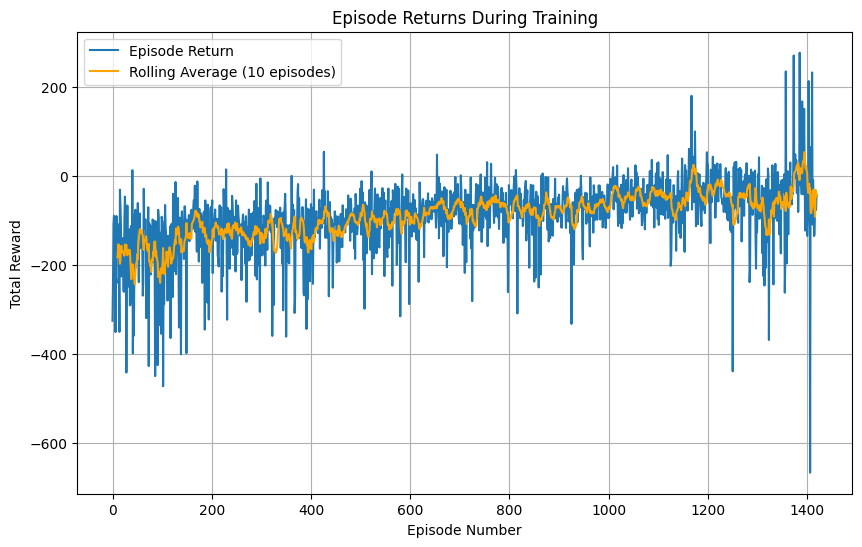

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'episode_returns' is available in the current environment
# after running the train.py script
if 'episode_returns' in locals():
    plt.figure(figsize=(10, 6))
    plt.plot(episode_returns, label='Episode Return')
    plt.xlabel('Episode Number')
    plt.ylabel('Total Reward')
    plt.title('Episode Returns During Training')
    plt.grid(True)

    # Optional: Plot a rolling average to smooth the curve
    if len(episode_returns) > 10:
        rolling_avg = np.convolve(episode_returns, np.ones(10)/10, mode='valid')
        plt.plot(np.arange(len(rolling_avg)) + 10, rolling_avg, label='Rolling Average (10 episodes)', color='orange')
        plt.legend()

    plt.show()
else:
    print("Episode returns not available. Please run the training script (cell with !python train.py) first.")

We see from the above plot that the agent is leaning slowly with rewards increasing with more episodes. After 200,000 steps its rewars are starting to become less negative, with earning some positive rewards. It may require more learning, but I ran some longer runs and training began to diverge. I adjusted the hyperparameters to arrive at this latest result.

In [10]:
%%writefile run_episodes.py

import gymnasium as gym
import torch
import numpy as np

from config import Config
from agent import DuelingDDQNAgent

def run_episodes(agent: DuelingDDQNAgent, env_id: str, num_episodes: int = 10, render: bool = True):
    """Runs episodes with a trained agent."""
    # Set render_mode to 'human' for rendering, or None otherwise
    env = gym.make(env_id, render_mode="human" if render else None)

    for episode in range(num_episodes):
        obs, info = env.reset()
        total_reward = 0
        terminated = False
        truncated = False
        while not terminated and not truncated:
            # Agent selects action (remove torch.no_grad() if running from here, or use agent.act if it handles device)
            # Assuming agent.act handles the device correctly
            action = agent.act(obs)
            # Step in the environment
            next_obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            obs = next_obs

        print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}")

    env.close()



Writing run_episodes.py


#### 6) Run a few episodes and show results
**(POINTS: 1 if successful)**

In [12]:
# This script loads the saved agent and runs some episodes.

import torch
from config import Config
from agent import DuelingDDQNAgent
from run_episodes import run_episodes
import gymnasium as gym

cfg = Config()

# Create a new instance of the agent
# You need to know the state_dim and n_actions of your environment
env = gym.make(cfg.env_id)
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
env.close() # Close the temporary environment

loaded_agent = DuelingDDQNAgent(state_dim=state_dim, n_actions=n_actions, cfg=cfg)

# Load the saved state dictionary into the agent's Q-network
try:
    loaded_agent.q.load_state_dict(torch.load("trained_dueling_ddqn_agent.pth"))
    print("Trained agent state dictionary loaded successfully.")

    # Run episodes with the loaded agent
    run_episodes(loaded_agent, cfg.env_id, num_episodes=10, render=True)

except FileNotFoundError:
    print("Error: trained_dueling_ddqn_agent.pth not found.")
    print("Please ensure you have trained the agent and saved its state dictionary.")
except Exception as e:
    print(f"An error occurred while loading or running episodes: {e}")

Trained agent state dictionary loaded successfully.
Episode 1: Total Reward = -290.46
Episode 2: Total Reward = -537.47
Episode 3: Total Reward = -108.63
Episode 4: Total Reward = -79.60
Episode 5: Total Reward = -215.55
Episode 6: Total Reward = -257.52
Episode 7: Total Reward = -40.50
Episode 8: Total Reward = -79.89
Episode 9: Total Reward = -98.86
Episode 10: Total Reward = -263.15
